Make sure you download the 2016 Household LSMS survey data for Malawi, Ethiopia, and Nigeria from https://microdata.worldbank.org/index.php/catalog/lsms and put it in `../data/countries/`. Malawi's data should be named `malawi_2016/LSMS`, Ethiopia's should be named `ethiopia_2015/LSMS`, and Nigeria's should be named `nigeria_2015/LSMS`. Nightlights data should be downloaded from https://ngdc.noaa.gov/eog/viirs/download_dnb_composites.html using the annual composite from 2015 in tile 2 and tile 5.

In [1]:
import pandas as pd
import numpy as np
import os
import geoio
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BASE_DIR = '..'

COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
OLD_TIFF_DIR = [os.path.join(BASE_DIR, '../predicting-poverty-ethiopia/data/temp_geotiff/wc2.1_2.5m_tmax_1970-08.tif')]
NEW_TIFF_DIR = [os.path.join(BASE_DIR, '../predicting-poverty-ethiopia/data/temp_geotiff/wc2.1_2.5m_tmax_2015-08.tif')]

In [3]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

In [41]:
'''
The goal of each of these functions is to output a dataframe with the following columns:
country, cluster_lat, cluster_lon, cons_pc

Each row should represent one cluster by combining the household data
'''

def process_ethiopia():
    lsms_dir = os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'LSMS_2018')
    consumption_file = 'cons_agg_w4.csv'
    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household
    
#     geovariables_file = 'Geovariables/ETH_HouseholdGeovars_y3.csv'
    geovariables_file = 'ETH_HouseholdGeovariables_Y4.csv'
    lat_col = 'lat_mod'
    lon_col = 'lon_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 10.74
    
    for file in [consumption_file, geovariables_file]:
        assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df_c = pd.read_csv(os.path.join(lsms_dir, consumption_file))
    print(df_c)
    df_c['cons_ph'] = df_c[consumption_pc_col] * df_c[hhsize_col]
    df_c['pph'] = df_c[hhsize_col]
    df_c['cons_ph'] = df_c['cons_ph'] / ppp / 365
    df = df_c[['household_id', 'cons_ph', 'pph']]
    
    df_geo = pd.read_csv(os.path.join(lsms_dir, geovariables_file))
    df_cords = df_geo[['household_id', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id')
    df_combined.drop(['household_id'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    #df_clusters['total_hv'] = df_clusters['total_hv']
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [42]:
df_eth = process_ethiopia()

            household_id            ea_id              saq01  saq14  \
0     010601010100215268   10601010100215             TIGRAY  URBAN   
1     150101088802908013  150101088802908          DIRE DAWA  RURAL   
2     060206088800904010   60206088800904  BENISHANGUL GUMUZ  RURAL   
3     150101088802010033  150101088802010          DIRE DAWA  RURAL   
4     040212088800506137   40212088800506             OROMIA  RURAL   
...                  ...              ...                ...    ...   
6765  050109088800301014   50109088800301             SOMALI  RURAL   
6766  140104010100403195  140104010100403        ADDIS ABABA  URBAN   
6767  020503010100101104   20503010100101               AFAR  URBAN   
6768  030701088800919090   30701088800919             AMHARA  RURAL   
6769  010701088800415040   10701088800415             TIGRAY  RURAL   

             pw_w4  adulteq  hh_size  food_cons_ann  nonfood_cons_ann  \
0      2323.239910     0.74        1   20709.000000            3940.0   
1

/var/folders/yw/3z56n_vx4vq9g05qrxzrr4m40000gn/T/ipykernel_68886/2605403441.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


KeyError: "['cons_pc'] not in index"

In [43]:
df_eth.shape

(516, 4)

In [44]:
df_eth.head()

    country  cluster_lat  cluster_lon    cons_pc
0       eth     3.609384    39.021503  16.641462
1       eth     4.010758    41.765862   8.226561
2       eth     4.439883    41.876270  18.858865
3       eth     4.730678    41.537197  16.841644
4       eth     4.744136    36.045395   5.768457
..      ...          ...          ...        ...
511     eth    14.284902    39.466244  32.288105
512     eth    14.335057    39.771530  13.929745
513     eth    14.375913    38.154888  11.341028
514     eth    14.402184    37.758106   9.582634
515     eth    14.477154    39.540272  21.564621

[516 rows x 4 columns]


In [47]:
old_tifs = [geoio.GeoImage(ndir) for ndir in OLD_TIFF_DIR]
new_tifs = [geoio.GeoImage(ndir) for ndir in NEW_TIFF_DIR]

In [48]:
old_tif_array = np.squeeze(old_tifs[0].get_data())
new_tif_array = np.squeeze(new_tifs[0].get_data())

In [49]:
new_tif_array.shape

(4320, 8640)

In [50]:
#tif, tif_array = old tif
def add_temps(df, tif, new_tif, tif_array, new_tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_temps = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_temps.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
    
    new_cluster_temps = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = new_tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = new_tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= new_tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= new_tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        new_cluster_temps.append(new_tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    array1 = np.array(new_cluster_temps)
    array2 = np.array(cluster_temps)
    subtracted_array = np.subtract(array1, array2)
    delta_temps = list(subtracted_array)
    df['temp'] = delta_temps

In [51]:
add_temps(df_eth, old_tifs[0], new_tifs[0], old_tif_array, new_tif_array)

/var/folders/yw/3z56n_vx4vq9g05qrxzrr4m40000gn/T/ipykernel_31367/536466376.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = delta_temps


In [52]:
df_eth.head()

,country,cluster_lat,cluster_lon,cons_pc,temp
0,eth,3.609384,39.021503,16.641462,2.225000
1,eth,4.010758,41.765862,8.226561,1.557117
2,eth,4.439883,41.876270,18.858865,1.662502
3,eth,4.730678,41.537197,16.841644,1.847916
4,eth,4.744136,36.045395,5.768457,2.642365


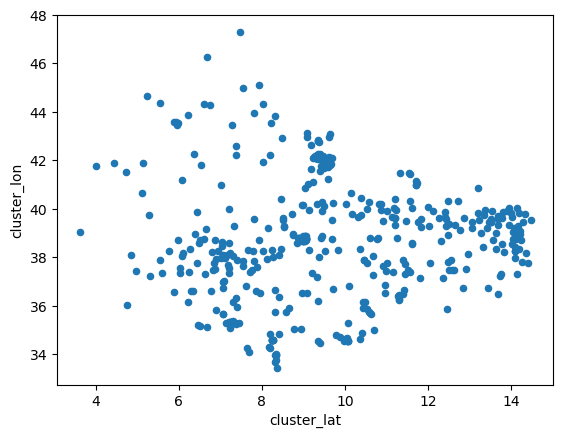

In [9]:
df_eth.plot.scatter(x="cluster_lat", y="cluster_lon")
x = df_eth['cluster_lat']
y = df_eth['cluster_lon']
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.plot(x, y)
# plt.xlim([0,])
# plt.ylim() 
plt.show()

In [37]:
for country in ['ethiopia_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'processed'), exist_ok=True)

In [38]:
df_eth.to_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'), index=False)